In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import seaborn as sns

from datetime import timedelta

import xrft

from glob import glob

In [9]:
# data = pd.read_csv('../data/Aranet4 160BB_2023-05-03T10_50_07+0200.csv',index_col=0,parse_dates=True,dayfirst=True)
# data2 = pd.read_csv('../data/Aranet4 160BB_2023-05-11T08_37_53+0200.csv',index_col=0,parse_dates=True,dayfirst=True)

files = glob('../data/Aranet*.csv')
datas = [pd.read_csv(f,index_col=0,parse_dates=True,dayfirst=True) for f in files]
data = pd.concat(datas).sort_index().dropna(how='all')
data = data[~data.index.duplicated(keep='first')]

In [10]:
datax = data.to_xarray()

In [11]:
rename_dict = {
    'Relative humidity' : 'hur',
    'Temperature': 'ta',
    'Carbon dioxide' : 'co2',
    'Atmospheric pressure': 'pa'
}

In [12]:
for d in datax:
    long_name, unit = d.split('(')[0], d.split('(')[1][:-1]
    name = rename_dict[long_name]
    datax = datax.rename({d:name})
    datax[name].attrs['units'] = unit
    datax[name].attrs['long_name'] = long_name
    print(name,unit)

for d in datax.indexes:
    name = d.split('(')[0]
    datax = datax.rename({d:name.lower()})

co2 ppm
ta °C
hur %
pa hPa


In [13]:
datax.to_dataframe().describe()

,co2,ta,hur,pa
count,67087.000000,66973.000000,66973.000000,66973.000000
mean,682.801064,21.602072,40.547564,1009.200105
std,309.028966,1.609677,6.402317,9.396919
min,415.000000,15.800000,15.000000,805.200000
25%,486.000000,20.500000,36.000000,1005.100000
50%,572.000000,21.800000,40.000000,1009.400000
75%,773.000000,22.600000,44.000000,1014.800000
max,4461.000000,32.200000,63.000000,1025.800000


Text(0.5, 0.98, 'Distribution of one-minute observations')

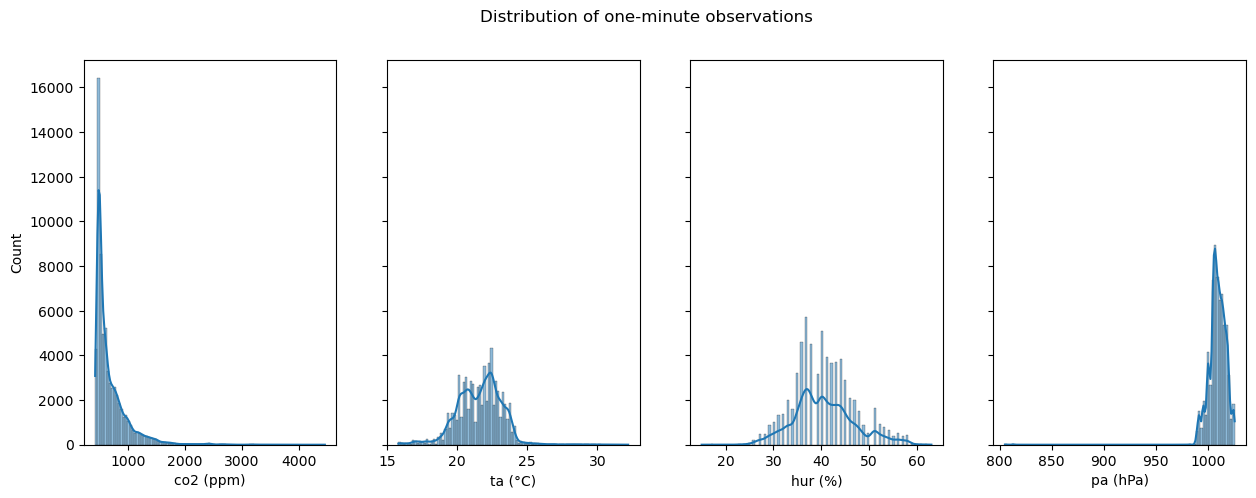

In [14]:
fig, ax = plt.subplots(1,4,sharey=True,figsize=(15,5))
i = 0
for d in datax:
    sns.histplot(data=datax[d],kde=True,bins=100,ax=ax[i])
    ax[i].set_xlabel('%s (%s)' % (d,datax[d].attrs['units']))
    i += 1
fig.suptitle('Distribution of one-minute observations')

Text(0.5, 0.98, 'Distribution of one-hourly means')

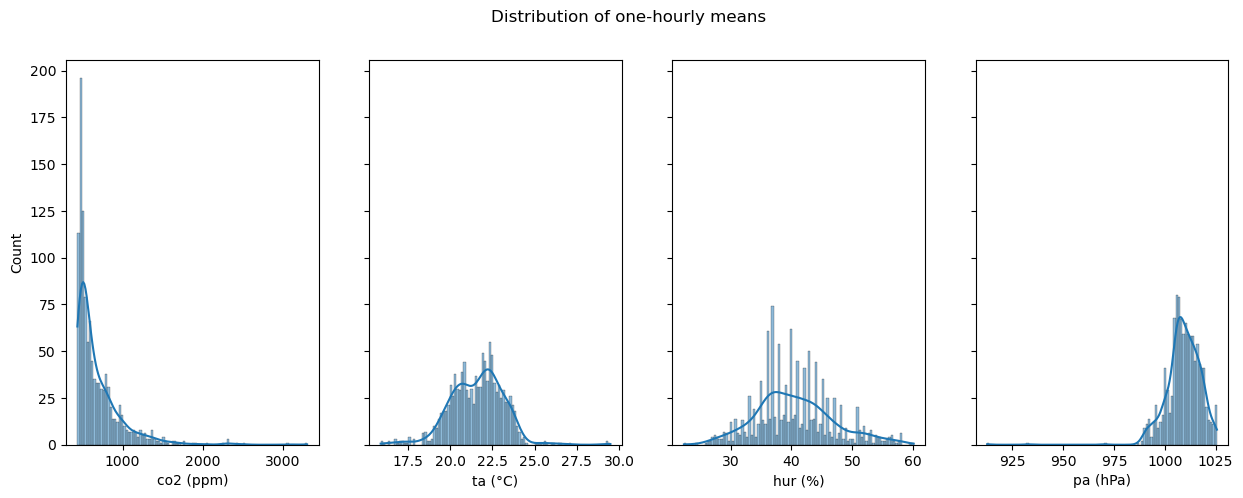

In [15]:
fig, ax = plt.subplots(1,4,sharey=True,figsize=(15,5))
i = 0
for d in datax:
    sns.histplot(data=datax[d].resample(time='1H').mean(),kde=True,bins=100,ax=ax[i])
    ax[i].set_xlabel('%s (%s)' % (d,datax[d].attrs['units']))
    i += 1
fig.suptitle('Distribution of one-hourly means')

/Users/neam/miniconda3/envs/short310/lib/python3.10/site-packages/xarray/core/common.py:975: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  grouper = pd.Grouper(
/Users/neam/miniconda3/envs/short310/lib/python3.10/site-packages/xarray/core/common.py:975: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  grouper = pd.Grouper(
/Users/neam/miniconda3/envs/short310/lib/python3.10/site-packages/xarray/core/common.py:975: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

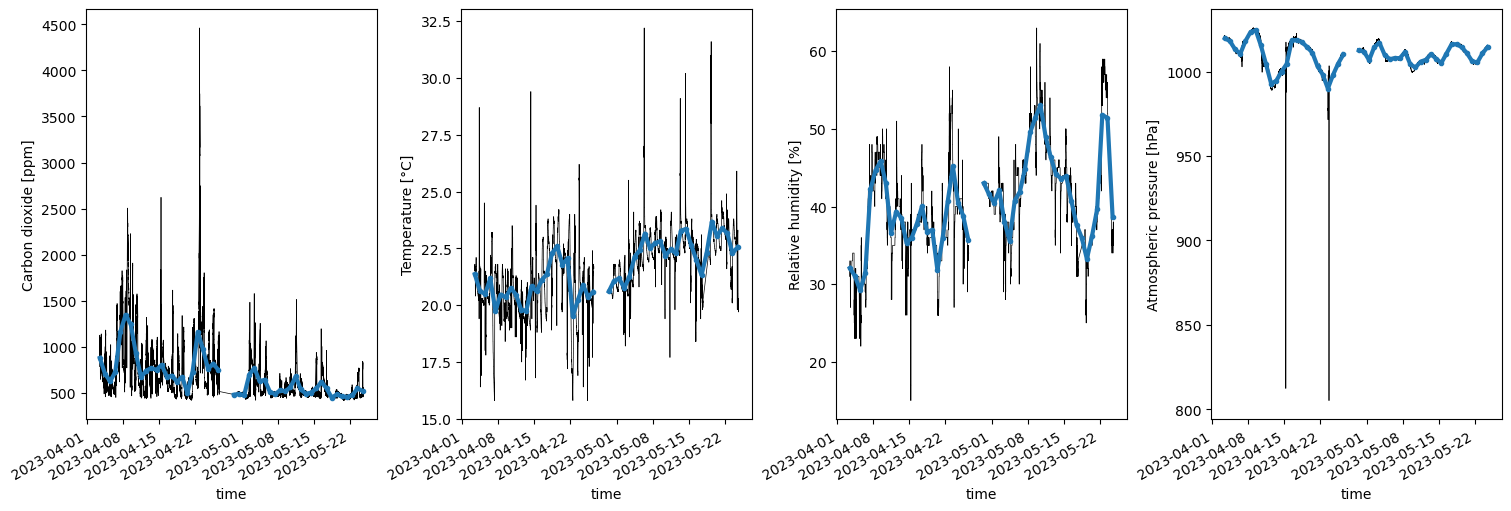

In [16]:
fig, ax = plt.subplots(1,4,sharex=True,figsize=(15,5),constrained_layout=True)

i = 0
for d in datax:
    datax[d].plot.line('-',lw=0.5,color='k',ax=ax[i])
    datax[d].resample(time='1D',loffset=timedelta(hours=12)).mean().plot.line('.-',lw=3,ax=ax[i])
    i += 1

## Stats

(0.0, 1.0)

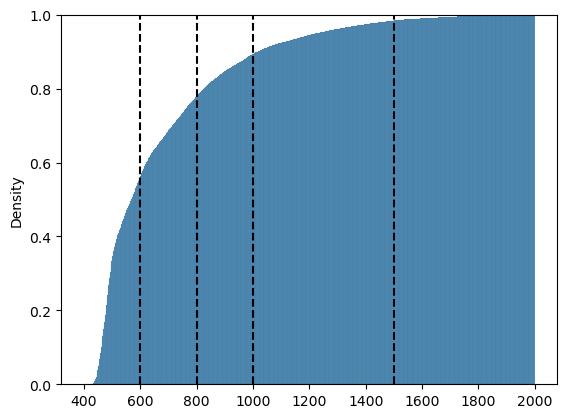

In [17]:
sns.histplot(
    data=datax.co2,
    # bins=1000,
    bins=np.linspace(400,2000,1000),
    kde=False,cumulative=True,stat='density')
plt.vlines([600,800,1000,1500],0,1,'k',linestyles='--')
# plt.grid(True)
plt.ylim(0,1)

In [18]:
levels = [600,800,1000,1500]
s = pd.Series(index=levels)
for l in levels:
    s[l] = (datax.co2<l).mean().round(2)

/var/folders/b7/jlnf3dqd463bk1y7gy48px3m0000gn/T/ipykernel_52014/680490677.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(index=levels)


In [19]:
print('Share of obs below CO2 level: ')
print(s)

Share of obs below CO2 level: 
600     0.56
800     0.77
1000    0.89
1500    0.98
dtype: float64


## Stats for working time

In [20]:
datax_weekday_worktime = datax.sel(
    time=(
        (datax['time.hour'] >= 8)   # after 8am
        * (datax['time.hour'] <= 17)  # before 6pm
        * (datax['time.weekday'] <= 4) 
    )
)

(0.0, 1.0)

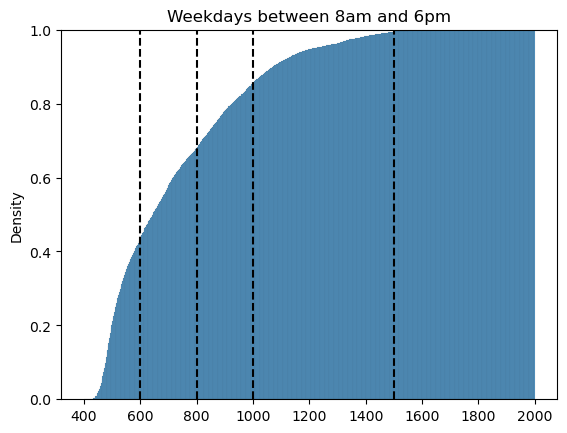

In [21]:
sns.histplot(data=datax_weekday_worktime.co2,
    bins=np.linspace(400,2000,1000),kde=False,cumulative=True,stat='density')
plt.vlines([600,800,1000,1500],0,1,'k',linestyles='--')
# plt.grid(True)
plt.title('Weekdays between 8am and 6pm')
plt.ylim(0,1)

In [22]:
levels = [600,800,1000,1500]
swork = pd.Series(index=levels)
for l in levels:
    swork[l] = (datax_weekday_worktime.co2<l).mean().round(2)

/var/folders/b7/jlnf3dqd463bk1y7gy48px3m0000gn/T/ipykernel_52014/518504554.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  swork = pd.Series(index=levels)


In [23]:
print('Share of obs below CO2 level: ')
print(swork)

Share of obs below CO2 level: 
600     0.43
800     0.68
1000    0.86
1500    0.99
dtype: float64


## Non-working

In [24]:
datax_non_working = datax.sel(time=[d for d in datax.time.values if not d in datax_weekday_worktime.time.values])

(0.0, 1.0)

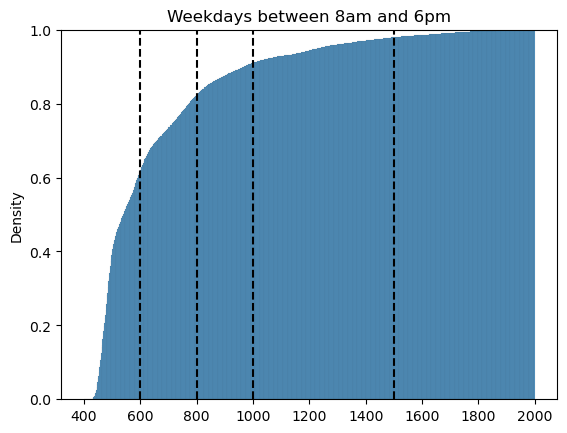

In [25]:
sns.histplot(data=datax_non_working.co2,
    bins=np.linspace(400,2000,1000),kde=False,cumulative=True,stat='density')
plt.vlines([600,800,1000,1500],0,1,'k',linestyles='--')
# plt.grid(True)
plt.title('Weekdays between 8am and 6pm')
plt.ylim(0,1)

In [26]:
levels = [600,800,1000,1500]
snonwork = pd.Series(index=levels)
for l in levels:
    snonwork[l] = (datax_non_working.co2<l).mean().round(2)

/var/folders/b7/jlnf3dqd463bk1y7gy48px3m0000gn/T/ipykernel_52014/2693193494.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  snonwork = pd.Series(index=levels)


In [27]:
print('Share of obs below CO2 level: ')
print(snonwork)

Share of obs below CO2 level: 
600     0.61
800     0.81
1000    0.90
1500    0.97
dtype: float64


## Comparison

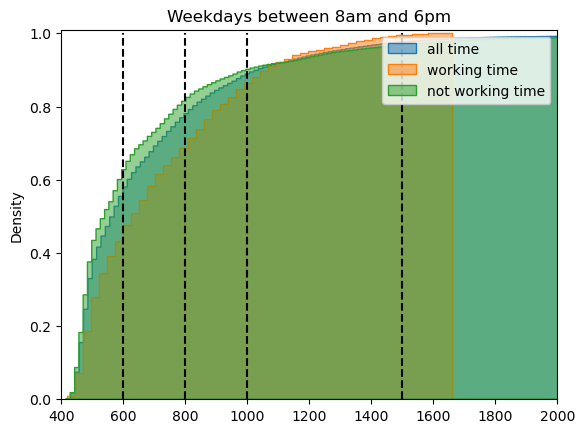

In [28]:
sns.histplot(
    data=datax.co2,
    # bins=np.linspace(400,2000,2000),
    alpha=0.5,
    kde=False,cumulative=True,stat='density',
    element='step',
    label='all time')
sns.histplot(
    data=datax_weekday_worktime.co2,
    # bins=np.linspace(400,2000,2000),
    alpha=0.5,
    kde=False,cumulative=True,stat='density',
    element='step',
    label='working time')
sns.histplot(
    data=datax_non_working.co2,
    # bins=np.linspace(400,2000,2000),
    alpha=0.5,
    kde=False,cumulative=True,stat='density',
    element='step',
    label='not working time')
plt.vlines([600,800,1000,1500],0,1,'k',linestyles='--')
# plt.grid(True)
plt.title('Weekdays between 8am and 6pm')
plt.ylim(0,1.01)
plt.xlim(400,2000)
plt.legend()

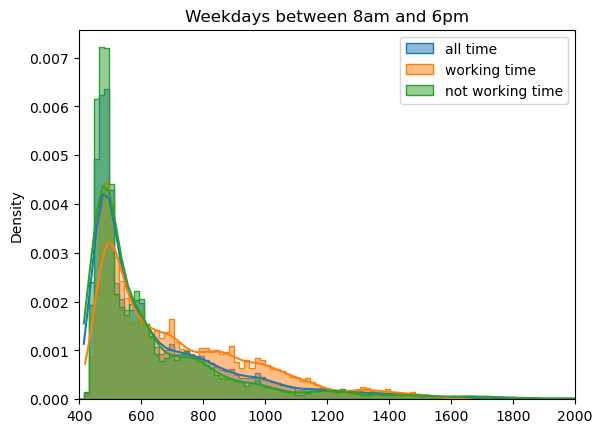

In [29]:
sns.histplot(
    data=datax.co2,
    bins=np.linspace(400,2000,100),
    alpha=0.5,
    kde=True,cumulative=False,stat='density',
    element='step',
    label='all time')
sns.histplot(
    data=datax_weekday_worktime.co2,
    bins=np.linspace(400,2000,100),
    alpha=0.5,
    kde=True,cumulative=False,stat='density',
    element='step',
    label='working time')
sns.histplot(
    data=datax_non_working.co2,
    bins=np.linspace(400,2000,100),
    alpha=0.5,
    kde=True,cumulative=False,stat='density',
    element='step',
    label='not working time')
# plt.vlines([600,800,1000,1500],0,1,'k',linestyles='--')
# plt.grid(True)
plt.title('Weekdays between 8am and 6pm')
# plt.ylim(0,1.01)
plt.xlim(400,2000)
plt.legend()

In [30]:
datax_minute = datax.resample(time='T').mean()

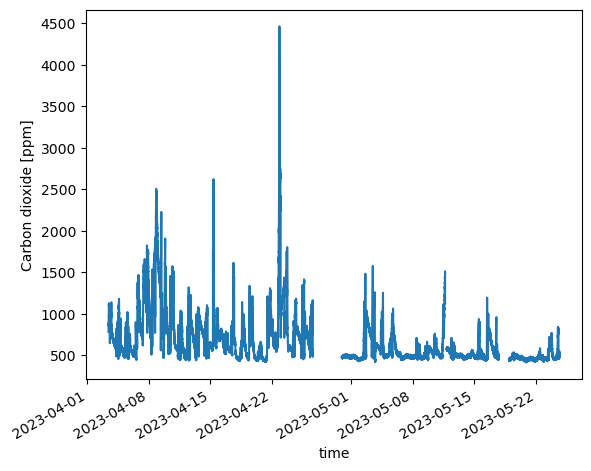

In [31]:
datax_minute.co2.plot()

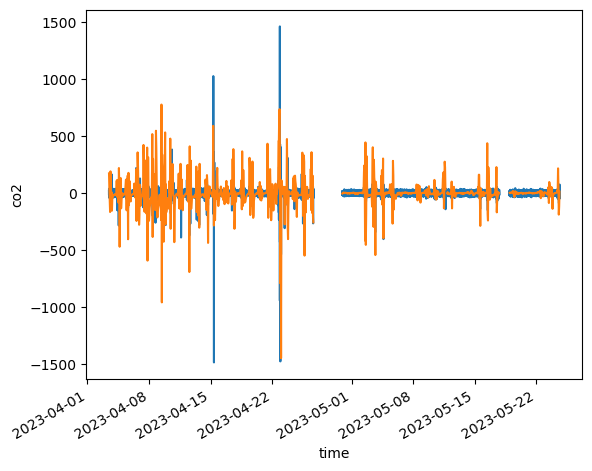

In [32]:
datax_minute.co2.diff('time').plot()
datax_minute.co2.resample(time='1H').mean().diff('time').plot()

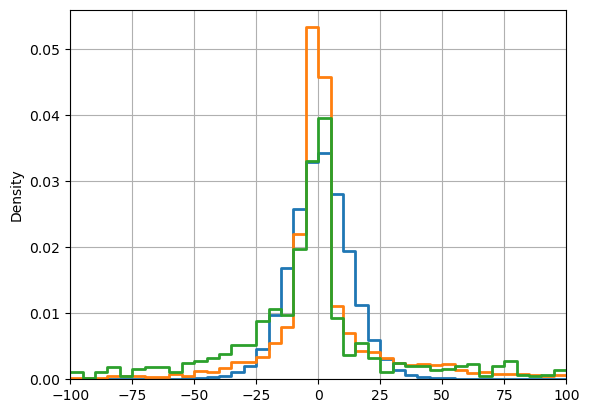

In [33]:
sns.histplot(datax_minute.co2.diff('time'),bins=np.arange(-100,101,5),stat='density',element='step',fill=False,lw=2)#,kde=True)
sns.histplot(datax_minute.co2.resample(time='10T').mean().diff('time'),bins=np.arange(-100,101,5),stat='density',element='step',fill=False,lw=2)#,kde=True)
sns.histplot(datax_minute.co2.resample(time='1H').mean().diff('time'),bins=np.arange(-100,101,5),stat='density',element='step',fill=False,lw=2)#,kde=True)
# plt.semilogy()
plt.xlim(-100,100)
plt.grid(True)

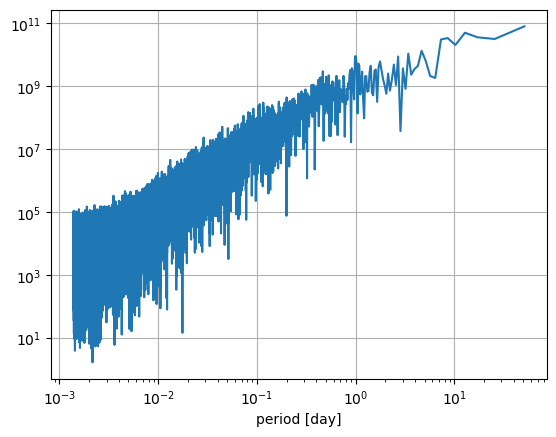

In [34]:
spectrum = xrft.power_spectrum(datax_minute.co2.fillna(0.),real_dim='time')
spectrum['period'] = 1/spectrum['freq_time'] / 86400
spectrum['period'].attrs['units'] = 'day'
spectrum.plot(x='period')
plt.loglog()
plt.grid(True)

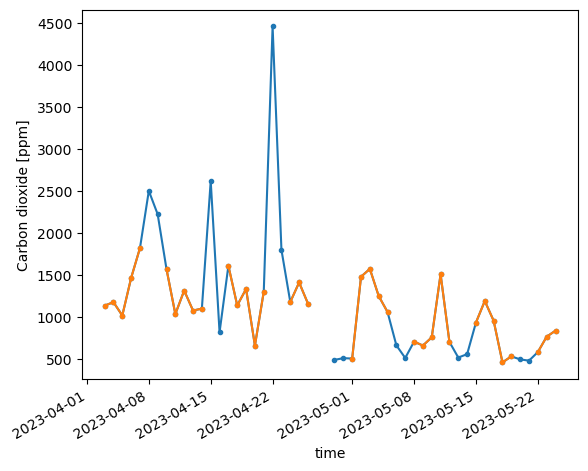

In [35]:
datax_minute.co2.resample(time='1D').max().plot.line('.-')
datax_minute.co2.sel(
    time=datax_minute['time.weekday']<=4
).resample(time='1D').max().plot.line('.-')

All data NaN for date 2023-04-27
All data NaN for date 2023-04-28


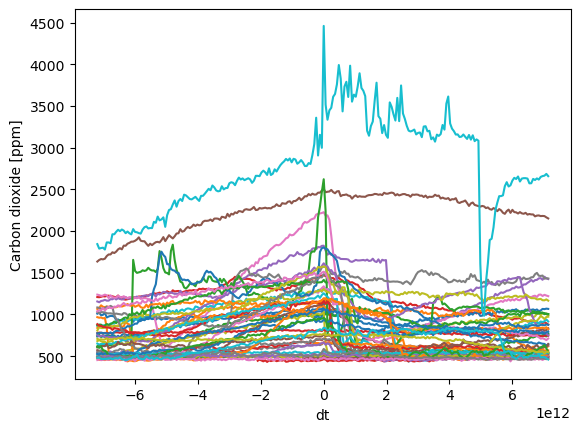

In [36]:
time_days = pd.date_range(datax_minute['time'].values[0],datax_minute['time'].values[-1],freq='D')

for date in time_days:
    date_str = str(date)[:10]
    datai_day = datax_minute.co2.sel(time=date_str)
    if datai_day.sum() == 0:
        print('All data NaN for date %s' % date_str)
        continue
    isel_peak = datai_day.argmax().values
    sel_peak = datai_day.idxmax()

    isel_left = max(isel_peak - 120,0)
    isel_right = isel_peak + 120
    datai = datai_day.isel(time=slice(isel_left,isel_right))
    datai['dt'] = datai['time'] - sel_peak

    datai.plot(x='dt')
# datax_minute.co2.sel(time='2023-04-05').isel(time=slice(datax_minute.co2.sel(time='2023-04-05').argmax().values-120,datax_minute.co2.sel(time='2023-04-05').argmax().values+120)).plot()

All data NaN for date 2023-04-27
All data NaN for date 2023-04-28


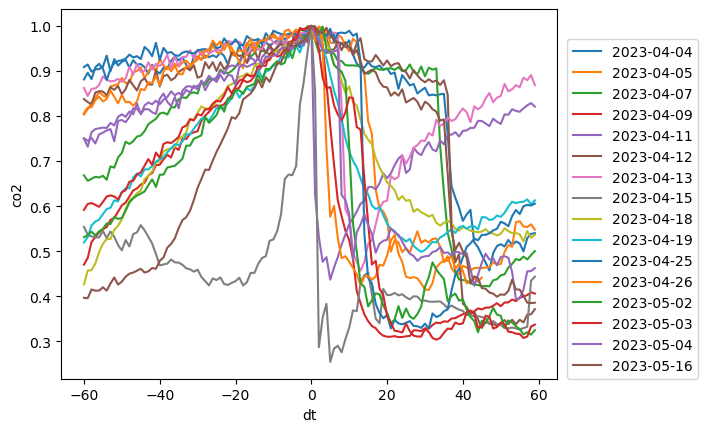

In [37]:
datas_rel = []
for date in time_days:
    date_str = str(date)[:10]
    datai_day = datax_minute.co2.sel(time=date_str)
    if datai_day.sum() == 0:
        print('All data NaN for date %s' % date_str)
        continue
    isel_peak = datai_day.argmax().values
    sel_peak = datai_day.idxmax()

    # isel_left = max(isel_peak - 120,0)
    # isel_right = isel_peak + 120
    isel_left = max(isel_peak - 60,0)
    isel_right = isel_peak + 60
    datai = datai_day.isel(time=slice(isel_left,isel_right))
    datai['dt'] = (datai['time'] - sel_peak) / 60e9
    # datai = datai / datai.max()

    if datai_day.max() > 1000:
        datai_rel = datai / datai.max()
        if datai_rel.min() < 0.5:
            datai_rel.plot(x='dt',label=date_str)

            datas_rel.append(datai_rel.drop('time').assign_coords(day=date_str))

datas_rel = xr.concat(datas_rel,'day')
plt.legend(loc=(1.02,0))
# datax_minute.co2.sel(time='2023-04-05').isel(time=slice(datax_minute.co2.sel(time='2023-04-05').argmax().values-120,datax_minute.co2.sel(time='2023-04-05').argmax().values+120)).plot()


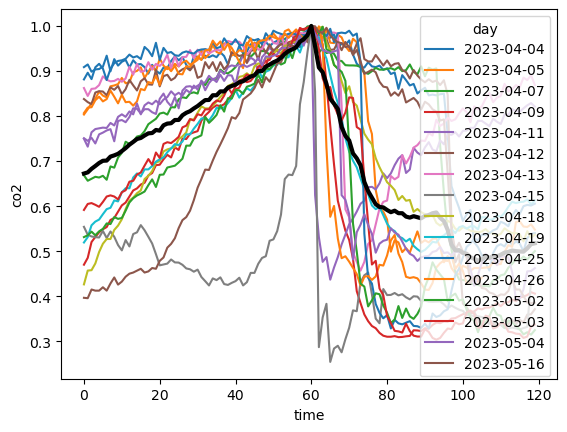

In [38]:
datas_rel.plot(hue='day')
datas_rel.mean('day').plot.line('k',lw=3)

All data NaN for date 2023-04-27
All data NaN for date 2023-04-28


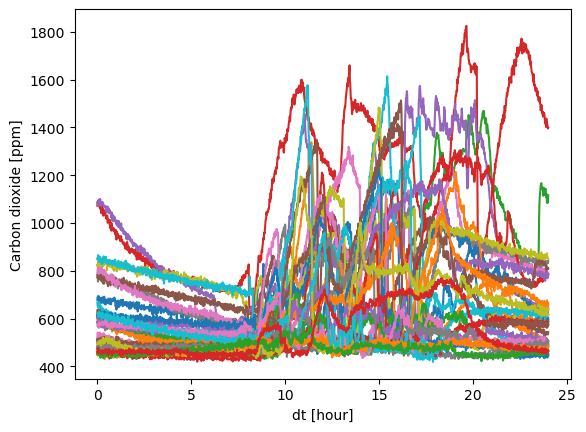

In [39]:
work_days = pd.date_range(datax_minute['time'].values[0],datax_minute['time'].values[-1],freq='B')

datas_days = []
# for date in work_days[-5:]:
for date in work_days[1:-1]:
    date_str = str(date)[:10]
    datai_day = datax_minute.co2.sel(time=date_str)
    if datai_day.sum() == 0:
        print('All data NaN for date %s' % date_str)
        continue
    # datai_day['dt'] = (datai_day['time'] - datai_day['time'][0]) / 60e9 
    datai_day['dt'] = (datai_day['time'] - datai_day['time'][0]).astype(float) / 1e9 / 60/60
    datai_day['dt'].attrs['units'] = 'hour'

    datai_day.plot(x='dt')
    datas_days.append(datai_day.drop('time').assign_coords(day=date_str))
datas_days = xr.concat(datas_days,'day')

(0.0, 24.0)

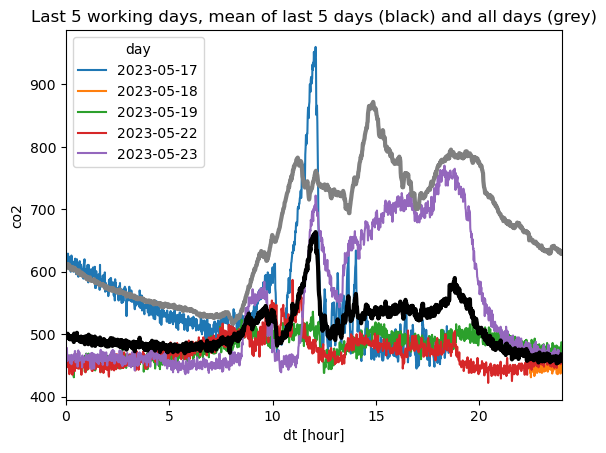

In [40]:
datas_days.isel(day=slice(-5,None)).plot(hue='day',x='dt')
datas_days.mean('day').plot.line('grey',x='dt',lw=3)
datas_days.isel(day=slice(-5,None)).mean('day').plot.line('k-',x='dt',lw=3)
# datas_days.quantile([0.16,0.84],'day').plot.line('k--',x='dt',lw=2,hue='quantile')

plt.title('Last 5 working days, mean of last 5 days (black) and all days (grey)')
plt.xlim(0,24)

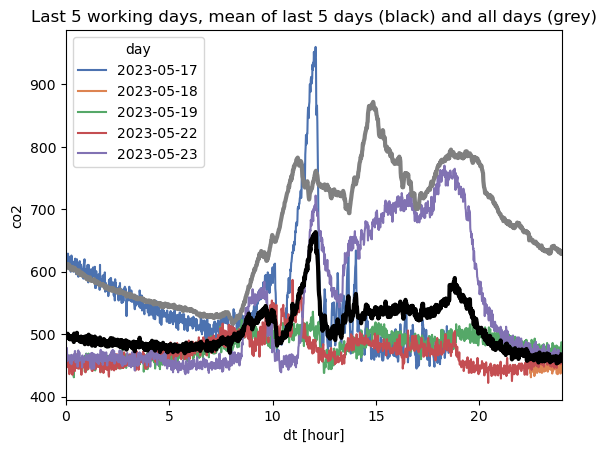

In [41]:
with sns.color_palette('deep'):
    datas_days.isel(day=slice(-5,None)).plot(hue='day',x='dt')
    datas_days.mean('day').plot.line('grey',x='dt',lw=3)
    datas_days.isel(day=slice(-5,None)).mean('day').plot.line('k-',x='dt',lw=3)
    # datas_days.quantile([0.16,0.84],'day').plot.line('k--',x='dt',lw=2,hue='quantile')

    plt.title('Last 5 working days, mean of last 5 days (black) and all days (grey)')
    plt.xlim(0,24)

(0.0, 100.0)

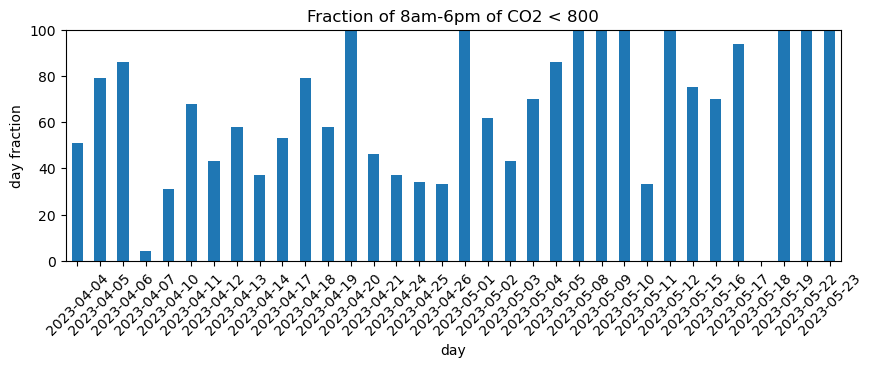

In [42]:
((datas_days.sel(time=(
    (datas_days['dt'] > 8)
    * (datas_days['dt'] < 18)
)
)<800).mean('time').to_pandas() * 100).astype(int).plot.bar(figsize=(10,3),rot=45)#(style='.-')
plt.ylabel('day fraction')
plt.title('Fraction of 8am-6pm of CO2 < 800')
# plt.grid(True)
plt.ylim(0,100)

<Axes: ylabel='Count'>

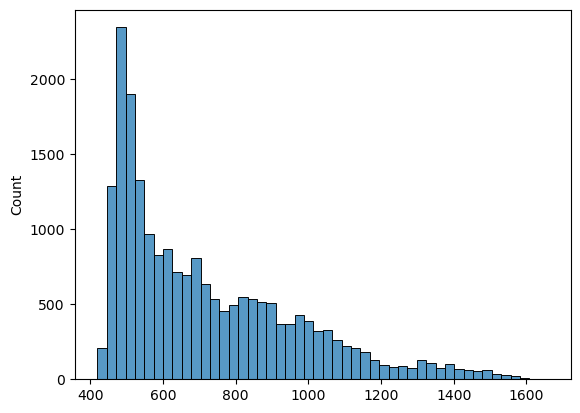

In [43]:
sns.histplot(datax_weekday_worktime.co2)

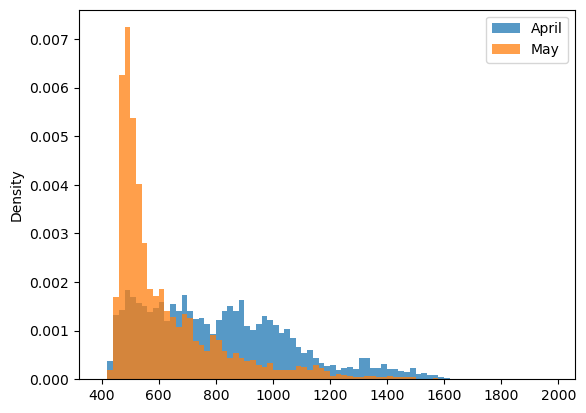

In [44]:
sns.histplot(datax_weekday_worktime.co2.sel(time='2023-04'),stat='density',bins=np.arange(400,2000,20),element='step',lw=0,label='April')
sns.histplot(datax_weekday_worktime.co2.sel(time='2023-05'),stat='density',bins=np.arange(400,2000,20),element='step',lw=0,label='May')
plt.legend()

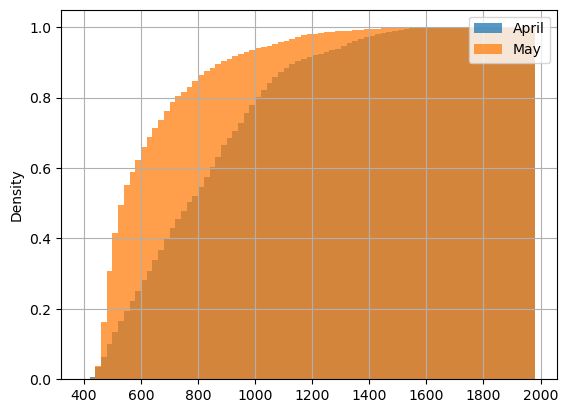

In [45]:
sns.histplot(datax_weekday_worktime.co2.sel(time='2023-04'),stat='density',cumulative=True,bins=np.arange(400,2000,20),element='step',lw=0,label='April')
sns.histplot(datax_weekday_worktime.co2.sel(time='2023-05'),stat='density',cumulative=True,bins=np.arange(400,2000,20),element='step',lw=0,label='May')
plt.legend()
plt.grid(True)